In [1]:
library(tidyverse)
library(vegan)
library(broom)
library(patchwork)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4



# KO Beta Diversity Analysis
##### Michael Shaffer
##### 7/25/22
##### Merck ESC, Sys bio group

Build out NMDS plots of KO data. Use them to check controls and color plots of baby samples based on metadata characteristics.

## Read in data

In [2]:
meta = read_csv('../../data/metadata/stool/stool_metadata.csv')
abx = read_csv('../../data/metadata/stool/stool_abx_usage.csv')
titers = read_csv('../../data/metadata/stool/stool_titers_yr1.csv')
meta = meta %>% left_join(abx, by='SampleID') %>% left_join(titers, by='SampleID')
meta = meta %>% mutate_at(vars(BabyN, Plate), factor)
meta = meta %>% filter(gt_2.5 == TRUE)
tail(meta)

Rows: 709 Columns: 26
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (11): SampleID, SubmissionType, DiversigenCheckInSampleName, BoxLocatio...
dbl   (7): SampleNumber, BabyN, Plate, Row, Column, age_at_collection, Count
lgl   (6): SampleIDValidation, BabyN_checked, DOB_checked, CollectionDate_ch...
date  (2): DOB, CollectionDate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 709 Columns: 6
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): SampleID
dbl (2): days_since_abx_start, days_since_abx_end
lgl (3): never_abx, on_abx, previous_abx

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set 

SampleID,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,⋯,median_mmNorm_PCV,median_mmNorm_DTAPHib,protectNorm_Dip,protectNorm_TET,protectNorm_PRP (Hib),protectNorm_PT,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2
<chr>,<chr>,<dbl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
101_V5,Primary in Tube,704,NA,NA,Box23,Stool,Human Infant,MetaG,101,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
105_V7,Primary in Tube,705,NA,NA,Box23,Stool,Human Infant,MetaG,105,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
216_V4,Primary in Tube,706,NA,NA,Box23,Stool,Human Infant,MetaG,216,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
101_S1,Primary in Tube,707,NA,NA,Box23,Stool,Human Infant,MetaG,101,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
102_V3,Primary in Tube,708,NA,NA,Box23,Stool,Human Infant,MetaG,102,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
236_A3F,Primary in Tube,709,NA,NA,NA,Stool,Human Infant,MetaG,236,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Build NMDS

We will just use TSS/relative abundance normalization on the raw, unadjusted data.

In [3]:
ko_abunds = t(read.table('../../data/stool/ko_abundance_table.rel.tsv', sep='\t', header=T, row.names=1, check.names=F, comment.char=""))
row.names(ko_abunds) = str_remove(row.names(ko_abunds), '.txt')
ko_abunds = ko_abunds[row.names(ko_abunds) %in% meta$SampleID | startsWith(row.names(ko_abunds), 'MSA2002') | startsWith(row.names(ko_abunds), 'GD5'),]
ko_abunds %>% head

,K00001,K00002,K00003,K00004,K00005,K00006,K00007,K00008,K00009,K00010,⋯,K22447,K22450,K22452,K22455,K22457,K22460,K22461,K22463,K22465,K22468
101_S1,0.0003033068,0,3.296546e-04,1.237737e-04,0.0010073462,0,3.798994e-05,7.291618e-05,2.530620e-04,1.648273e-04,⋯,0,0,0,0,2.450964e-06,0,0,0,0,5.759765e-05
101_V3,0.0002497238,0,4.899794e-04,1.207196e-04,0.0010770078,0,2.367050e-06,1.059255e-04,1.988322e-04,1.597759e-04,⋯,0,0,0,0,5.917625e-06,0,0,0,0,5.325863e-06
101_V5,0.0002796035,0,3.933638e-04,1.206133e-04,0.0012410834,0,5.002710e-05,2.247793e-04,2.713799e-04,1.082778e-04,⋯,0,0,0,0,1.370606e-06,0,0,0,0,4.180347e-05
102_V1,0.0001099041,0,6.532763e-05,0.000000e+00,0.0003573806,0,4.303938e-05,1.429522e-04,2.636162e-04,1.029871e-04,⋯,0,0,0,0,1.537121e-06,0,0,0,0,2.382537e-05
102_V3,0.0002081547,0,8.326189e-05,1.125161e-06,0.0001789005,0,4.838191e-05,5.063223e-05,9.113801e-05,9.338833e-05,⋯,0,0,0,0,0.000000e+00,0,0,0,0,3.150450e-05
102_V5,0.0008448294,0,1.064975e-03,1.084660e-05,0.0001301592,0,2.852253e-05,1.365868e-05,6.869511e-05,1.193126e-04,⋯,0,0,0,0,1.044487e-05,0,0,0,0,1.807766e-05


In [4]:
ko_abunds_gt10 = ko_abunds[, colSums(ko_abunds > 0) >= 10]
tail(ko_abunds_gt10)

,K00001,K00002,K00003,K00004,K00005,K00006,K00007,K00008,K00009,K00010,⋯,K22430,K22431,K22432,K22441,K22443,K22444,K22452,K22457,K22465,K22468
MSA2002_7A,0.0003863334,0,0.0006042504,0.0004127906,0.0001573213,0,0,4.665587e-05,0.0001430970,6.742342e-05,⋯,0,0,0,3.413844e-05,8.904443e-05,8.563059e-05,8.762200e-05,3.527639e-05,0,0.0002622970
MSA2002_7B,0.0003595179,0,0.0005689500,0.0004003722,0.0001677177,0,0,4.257449e-05,0.0001621271,5.633594e-05,⋯,0,0,0,3.698390e-05,9.719026e-05,8.041849e-05,7.783821e-05,3.999422e-05,0,0.0002653380
MSA2002_8A,0.0003753488,0,0.0005998068,0.0004094714,0.0001408732,0,0,4.100975e-05,0.0001311686,6.386252e-05,⋯,0,0,0,3.349652e-05,9.892429e-05,9.203716e-05,8.515002e-05,3.287041e-05,0,0.0002648416
MSA2002_8B,0.0003682732,0,0.0005954395,0.0004043252,0.0001612649,0,0,4.768168e-05,0.0001380055,6.202495e-05,⋯,0,0,0,3.954091e-05,1.279265e-04,9.226212e-05,7.714353e-05,2.868654e-05,0,0.0002508134
MSA2002_9A,0.0003615809,0,0.0005531211,0.0003878444,0.0001566036,0,0,5.057246e-05,0.0001305845,5.130540e-05,⋯,0,0,0,2.846228e-05,1.144599e-04,9.613654e-05,8.880720e-05,3.017246e-05,0,0.0002413797
MSA2002_9B,0.0003532764,0,0.0005563751,0.0003574058,0.0001601752,0,0,4.585748e-05,0.0001428971,5.411617e-05,⋯,0,0,0,2.336341e-05,1.202944e-04,1.066023e-04,8.291293e-05,2.694942e-05,0,0.0002456961


In [5]:
nmds_all = metaMDS(ko_abunds_gt10, dist='bray', k=2)

Run 0 stress 0.1158438 
Run 1 stress 0.159387 
Run 2 stress 0.136247 
Run 3 stress 0.1737107 
Run 4 stress 0.1473948 
Run 5 stress 0.179211 
Run 6 stress 0.1570106 
Run 7 stress 0.1401668 
Run 8 stress 0.4199043 
Run 9 stress 0.1615432 
Run 10 stress 0.1425949 
Run 11 stress 0.1424807 
Run 12 stress 0.1581679 
Run 13 stress 0.1314572 
Run 14 stress 0.1314763 
Run 15 stress 0.1308606 
Run 16 stress 0.1575848 
Run 17 stress 0.1452689 
Run 18 stress 0.1604644 
Run 19 stress 0.1729075 
Run 20 stress 0.1308663 
*** Best solution was not repeated -- monoMDS stopping criteria:
     3: no. of iterations >= maxit
     3: stress ratio > sratmax
    14: scale factor of the gradient < sfgrmin


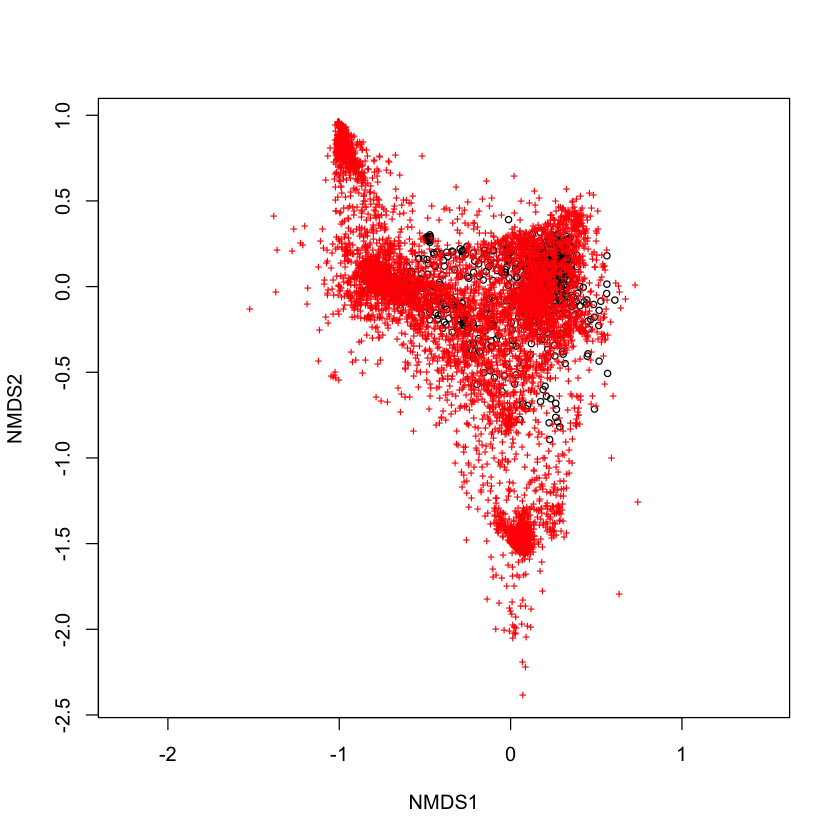

In [6]:
plot(nmds_all)

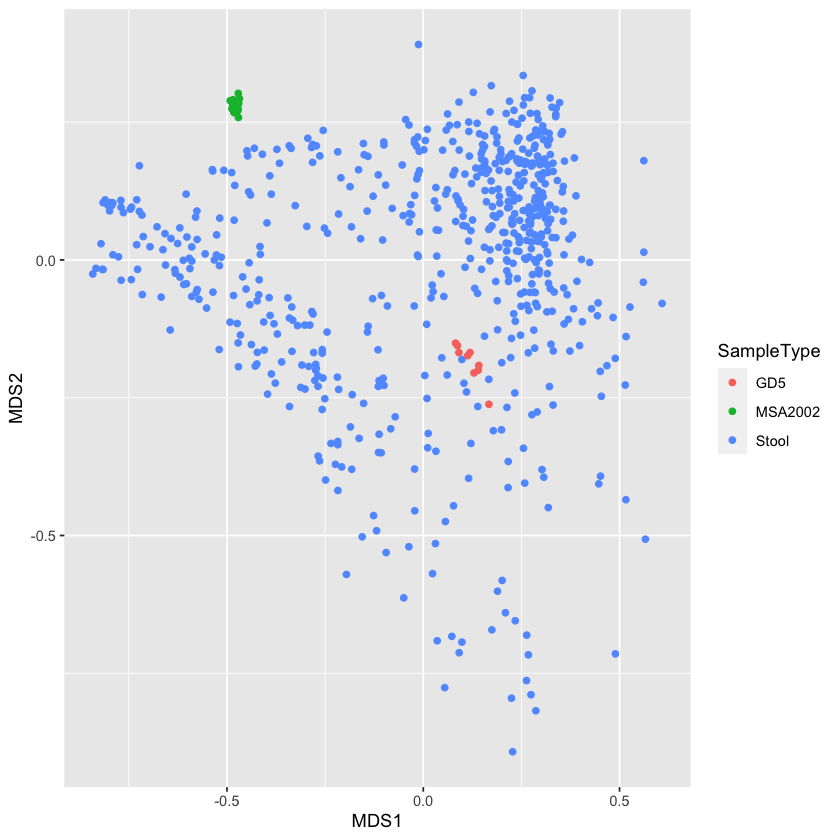

In [7]:
nmds_all_points = as_tibble(nmds_all$points, rownames='SampleID')
write_csv(nmds_all_points, '../../data/stool/ko_nmds_all.csv')
baby_samples_all = left_join(meta, nmds_all_points, by='SampleID')
control_samples_all = nmds_all_points %>%
                      filter(!SampleID %in% pull(baby_samples_all, SampleID)) %>%
                      separate(SampleID, 'SampleType', remove=F, extra='drop')
nmds_all_w_meta = bind_rows(baby_samples_all, control_samples_all)
ggplot(nmds_all_w_meta, aes(x=MDS1, y=MDS2, col=SampleType)) + geom_point()

In [8]:
head(control_samples_all)

SampleID,SampleType,MDS1,MDS2
<chr>,<chr>,<dbl>,<dbl>
GD5_1,GD5,0.08220231,-0.1509685
GD5_2,GD5,0.12923842,-0.2049946
GD5_3,GD5,0.14152785,-0.1913787
GD5_4,GD5,0.08739556,-0.1554869
GD5_5,GD5,0.11304151,-0.1737847
GD5_6,GD5,0.11901688,-0.1680536


This looks much more like we would expect. The MSA controls cluster together and apart from all baby samples. The GD5 samples cluster together and closer to the adult like sample than the baby samples. I don't think this is the ideal clustering but it is much better than our other normalization attempts.

### Controls only

In [9]:
ko_abunds_controls = ko_abunds_gt10[sapply(row.names(ko_abunds_gt10), function(x) startsWith(x, 'GD5') | startsWith(x, 'MSA2002')),]
nmds_controls = metaMDS(ko_abunds_controls, k=2)

Run 0 stress 9.812144e-05 
Run 1 stress 9.883826e-05 
... Procrustes: rmse 0.02487764  max resid 0.114449 
Run 2 stress 9.243744e-05 
... New best solution
... Procrustes: rmse 0.03664554  max resid 0.1629943 
Run 3 stress 9.416104e-05 
... Procrustes: rmse 0.02337792  max resid 0.09951232 
Run 4 stress 9.008055e-05 
... New best solution
... Procrustes: rmse 0.04544022  max resid 0.1934209 
Run 5 stress 9.301284e-05 
... Procrustes: rmse 0.03358016  max resid 0.1527209 
Run 6 stress 9.57523e-05 
... Procrustes: rmse 0.03103637  max resid 0.1425267 
Run 7 stress 9.611634e-05 
... Procrustes: rmse 0.03608338  max resid 0.1638311 
Run 8 stress 9.976068e-05 
... Procrustes: rmse 0.02955892  max resid 0.1282525 
Run 9 stress 9.908095e-05 
... Procrustes: rmse 0.01204308  max resid 0.05220495 
Run 10 stress 9.182158e-05 
... Procrustes: rmse 0.03755129  max resid 0.1704389 
Run 11 stress 9.514587e-05 
... Procrustes: rmse 0.02394411  max resid 0.1074126 
Run 12 stress 8.995537e-05 
... New 

Warning message in metaMDS(ko_abunds_controls, k = 2):
“stress is (nearly) zero: you may have insufficient data”


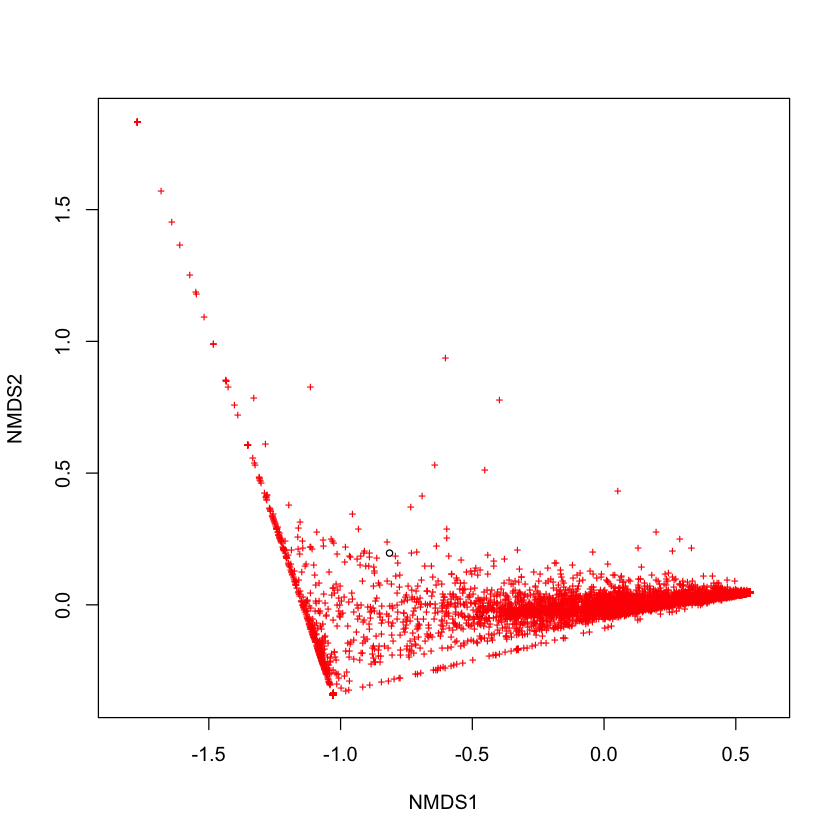

In [10]:
plot(nmds_controls)

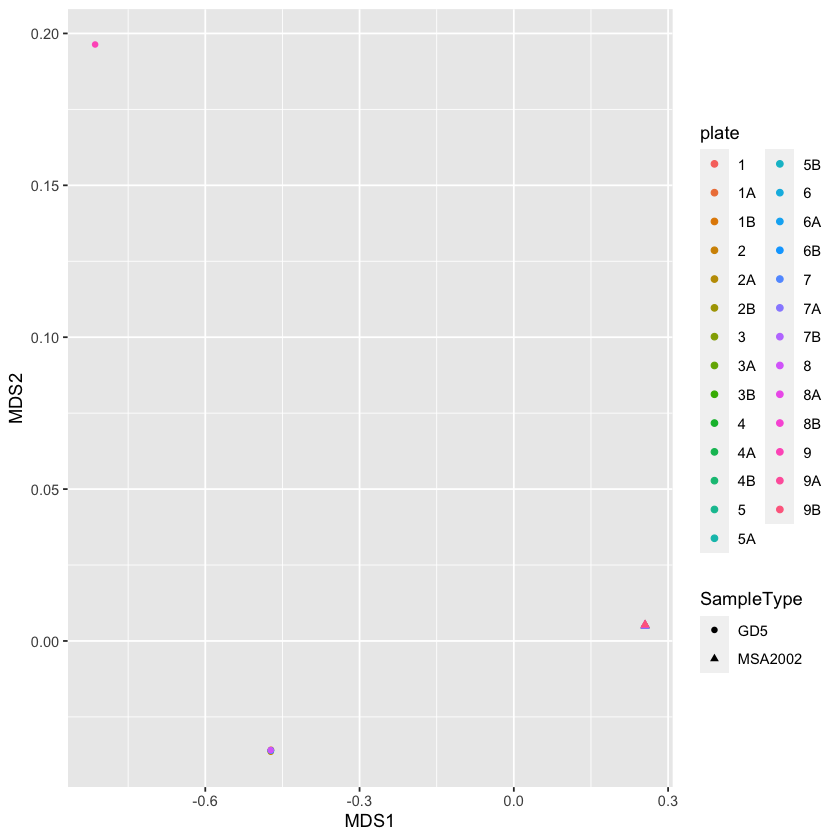

In [11]:
nmds_controls_points = as_tibble(nmds_controls$points, rownames='SampleID')
write_csv(nmds_controls_points, '../../data/stool/ko_nmds_controls.csv')
controls_only = nmds_controls_points %>% 
                separate(SampleID, c('SampleType', 'plate'), remove=F, extra='drop') %>%
                mutate_at(vars('plate'), as.factor)
ggplot(controls_only, aes(x=MDS1, y=MDS2, shape=SampleType, col=plate)) + geom_point()

One slight outlier in GD5_8 but the magnitude is pretty small and the MSA2002 samples from plate 8 are not outliers.

### Babies only

In [12]:
ko_abunds_babies = ko_abunds_gt10[sapply(row.names(ko_abunds_gt10), function(x) !(startsWith(x, 'GD5') | startsWith(x, 'MSA2002'))),]
ko_abunds_babies %>% head

,K00001,K00002,K00003,K00004,K00005,K00006,K00007,K00008,K00009,K00010,⋯,K22430,K22431,K22432,K22441,K22443,K22444,K22452,K22457,K22465,K22468
101_S1,0.0003033068,0,3.296546e-04,1.237737e-04,0.0010073462,0,3.798994e-05,7.291618e-05,2.530620e-04,1.648273e-04,⋯,2.450964e-06,0.000000e+00,6.127410e-07,0.000000e+00,6.923973e-05,3.370075e-05,0,2.450964e-06,0,5.759765e-05
101_V3,0.0002497238,0,4.899794e-04,1.207196e-04,0.0010770078,0,2.367050e-06,1.059255e-04,1.988322e-04,1.597759e-04,⋯,3.550575e-06,2.367050e-06,4.142338e-06,2.958813e-06,1.295960e-04,8.935614e-05,0,5.917625e-06,0,5.325863e-06
101_V5,0.0002796035,0,3.933638e-04,1.206133e-04,0.0012410834,0,5.002710e-05,2.247793e-04,2.713799e-04,1.082778e-04,⋯,2.055908e-06,6.304786e-05,9.662769e-05,0.000000e+00,6.784498e-05,4.180347e-05,0,1.370606e-06,0,4.180347e-05
102_V1,0.0001099041,0,6.532763e-05,0.000000e+00,0.0003573806,0,4.303938e-05,1.429522e-04,2.636162e-04,1.029871e-04,⋯,0.000000e+00,9.222724e-06,1.844545e-05,7.685603e-07,3.304809e-05,3.535378e-05,0,1.537121e-06,0,2.382537e-05
102_V3,0.0002081547,0,8.326189e-05,1.125161e-06,0.0001789005,0,4.838191e-05,5.063223e-05,9.113801e-05,9.338833e-05,⋯,0.000000e+00,1.012645e-05,1.462709e-05,0.000000e+00,4.050578e-05,2.925418e-05,0,0.000000e+00,0,3.150450e-05
102_V5,0.0008448294,0,1.064975e-03,1.084660e-05,0.0001301592,0,2.852253e-05,1.365868e-05,6.869511e-05,1.193126e-04,⋯,0.000000e+00,0.000000e+00,0.000000e+00,1.888111e-05,1.165005e-05,9.239694e-06,0,1.044487e-05,0,1.807766e-05


In [13]:
nmds_babies = metaMDS(ko_abunds_babies, k=3)

Run 0 stress 0.06592684 
Run 1 stress 0.06962208 
Run 2 stress 0.06909215 
Run 3 stress 0.06847745 
Run 4 stress 0.07020976 
Run 5 stress 0.08105003 
Run 6 stress 0.06943194 
Run 7 stress 0.06856027 
Run 8 stress 0.07198107 
Run 9 stress 0.07063349 
Run 10 stress 0.07282721 
Run 11 stress 0.07237224 
Run 12 stress 0.07090762 
Run 13 stress 0.07179705 
Run 14 stress 0.06780435 
Run 15 stress 0.06938727 
Run 16 stress 0.06775307 
Run 17 stress 0.06793442 
Run 18 stress 0.06906239 
Run 19 stress 0.07186554 
Run 20 stress 0.06983004 
*** Best solution was not repeated -- monoMDS stopping criteria:
     5: no. of iterations >= maxit
    15: scale factor of the gradient < sfgrmin


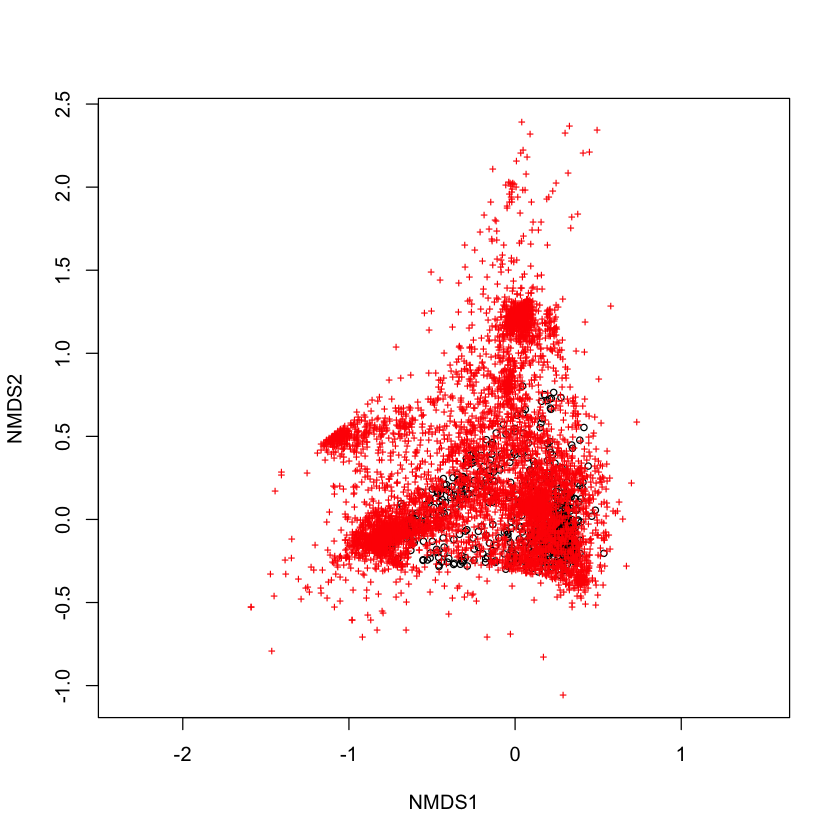

In [14]:
plot(nmds_babies)

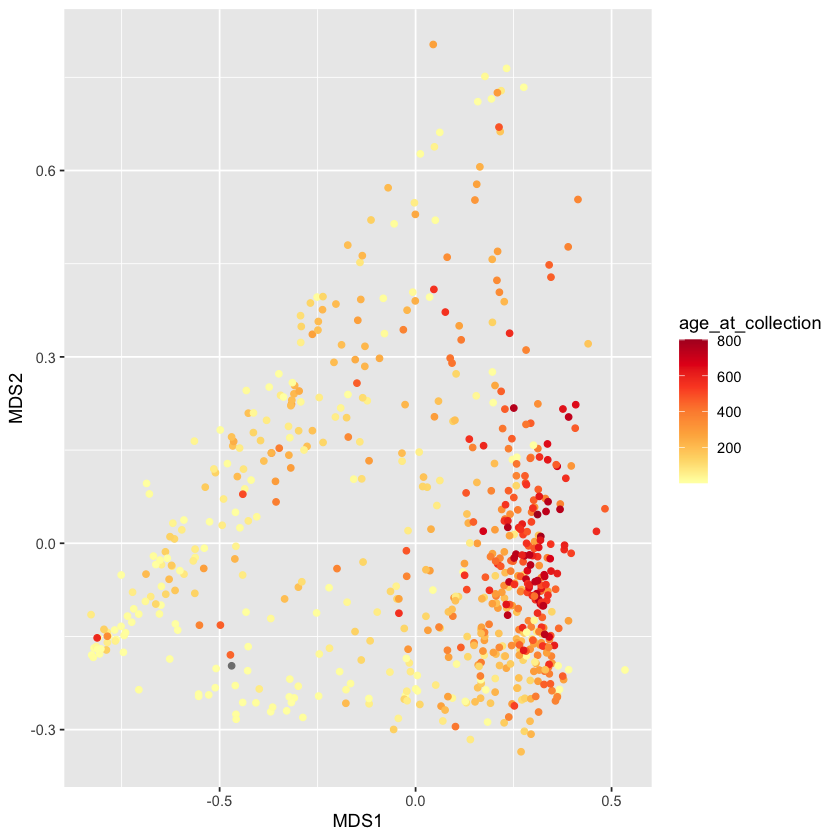

In [15]:
nmds_babies_points = as_tibble(nmds_babies$points, rownames='SampleID')
write_csv(nmds_babies_points, '../../data/stool/ko_nmds_babies.csv')
baby_samples_only = left_join(meta, nmds_babies_points, by='SampleID')
ggplot(baby_samples_only, aes(x=MDS1, y=MDS2, color=age_at_collection)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


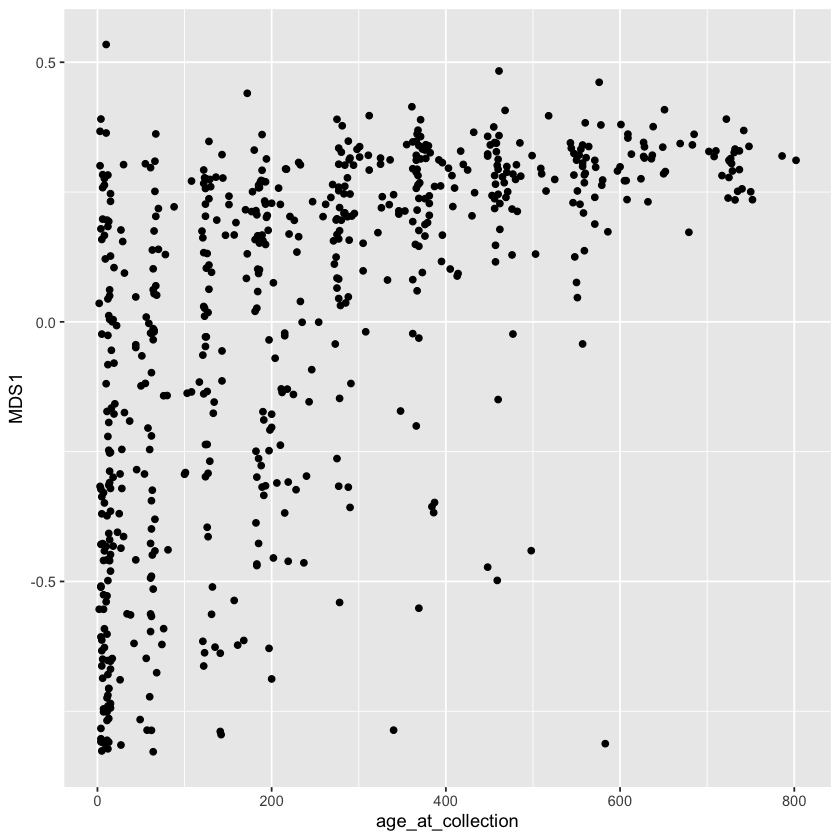

In [16]:
ggplot(baby_samples_only, aes(x=age_at_collection, y=MDS1)) + geom_point()

Clear age gradient as we saw in the kraken data. Clear decrease in variability over time.

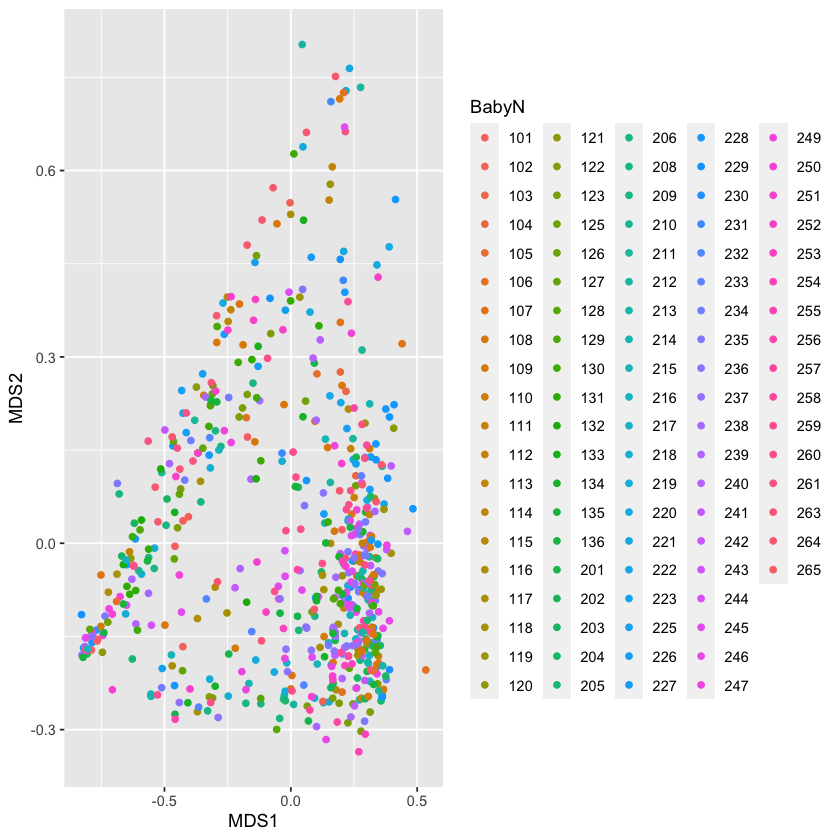

In [17]:
ggplot(baby_samples_only, aes(x=MDS1, y=MDS2, color=BabyN)) + geom_point()

No obvious clustering by baby.

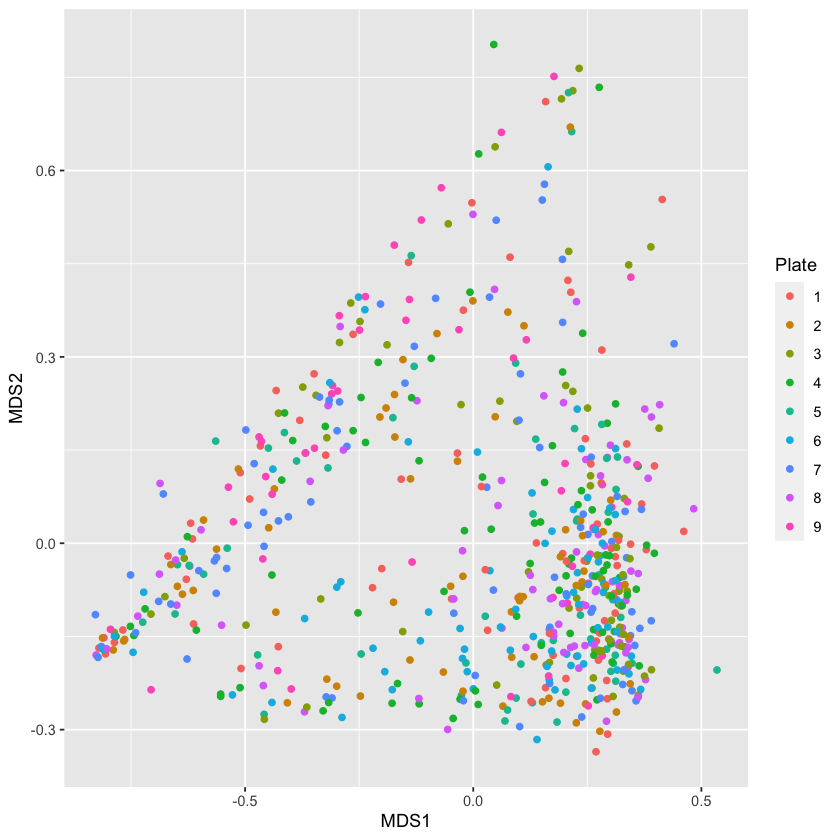

In [18]:
ggplot(baby_samples_only, aes(x=MDS1, y=MDS2, color=Plate)) + geom_point()

In [19]:
baby_bray_dists = tidy(vegdist(ko_abunds_babies, 'bray'))

baby_bray_dists = baby_bray_dists %>% left_join((meta %>% select(c("SampleID", "Plate"))), by=c('item1' = 'SampleID')) %>% rename(plate1 = Plate) %>%
                                      left_join((meta %>% select(c("SampleID", "Plate"))), by=c('item2' = 'SampleID')) %>% rename(plate2 = Plate) %>%
                                      mutate(same_plate = plate1 == plate2) %>%
                                      left_join((meta %>% select(c("SampleID", "BabyN"))), by=c('item1' = 'SampleID')) %>% rename(baby1 = BabyN) %>%
                                      left_join((meta %>% select(c("SampleID", "BabyN"))), by=c('item2' = 'SampleID')) %>% rename(baby2 = BabyN) %>%
                                      mutate(same_baby = baby1 == baby2) %>%
                                      left_join((meta %>% select(c("SampleID", "age_at_collection"))), by=c('item1' = 'SampleID')) %>% rename(age1 = age_at_collection) %>%
                                      left_join((meta %>% select(c("SampleID", "age_at_collection"))), by=c('item2' = 'SampleID')) %>% rename(age2 = age_at_collection) %>%
                                      mutate(age_diff = abs(age1 - age2)) %>%
                                      left_join((meta %>% select(c("SampleID", "collection_method"))), by=c('item1' = 'SampleID')) %>% rename(collection1 = collection_method) %>%
                                      left_join((meta %>% select(c("SampleID", "collection_method"))), by=c('item2' = 'SampleID')) %>% rename(collection2 = collection_method) %>%
                                      mutate(same_collection = collection1 == collection2)
head(baby_bray_dists)

item1,item2,distance,plate1,plate2,same_plate,baby1,baby2,same_baby,age1,age2,age_diff,collection1,collection2,same_collection
<chr>,<chr>,<dbl>,<fct>,<fct>,<lgl>,<fct>,<fct>,<lgl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>
101_S1,101_V3,0.1263240,7,7,TRUE,101,101,TRUE,44,23,21,Clinic,Clinic,TRUE
101_S1,101_V5,0.0703874,7,7,TRUE,101,101,TRUE,44,61,17,Clinic,Clinic,TRUE
101_S1,102_V1,0.2396150,7,1,FALSE,101,102,FALSE,44,6,38,Clinic,Clinic,TRUE
101_S1,102_V3,0.4095886,7,1,FALSE,101,102,FALSE,44,15,29,Clinic,Clinic,TRUE
101_S1,102_V5,0.4955410,7,1,FALSE,101,102,FALSE,44,59,15,Clinic,Clinic,TRUE
101_S1,103_S1,0.4604539,7,3,FALSE,101,103,FALSE,44,448,404,Clinic,Home,FALSE


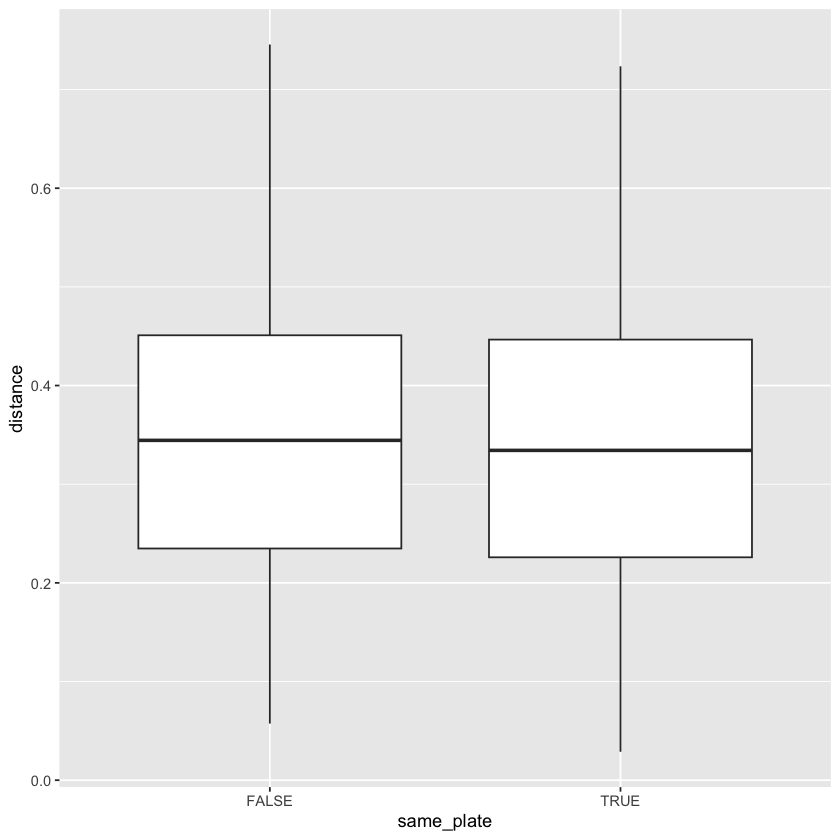

In [20]:
baby_bray_dists %>% ggplot(aes(same_plate, distance)) + geom_boxplot()

No significant plate effect.

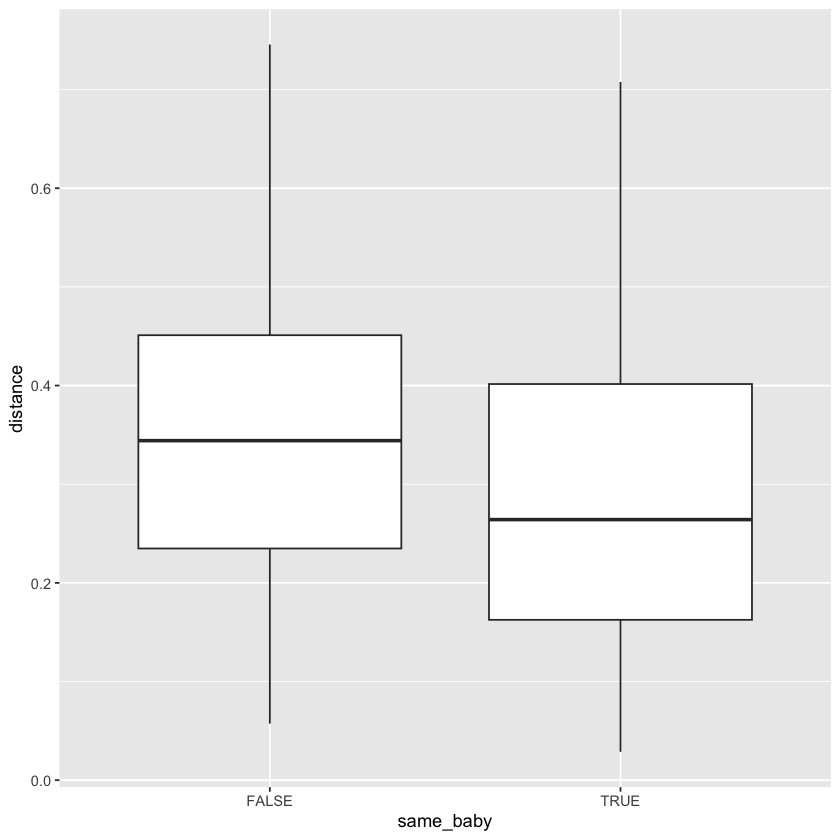

In [21]:
baby_bray_dists %>% ggplot(aes(same_baby, distance)) + geom_boxplot()

Babies are more similar to each other than samples from different babies.

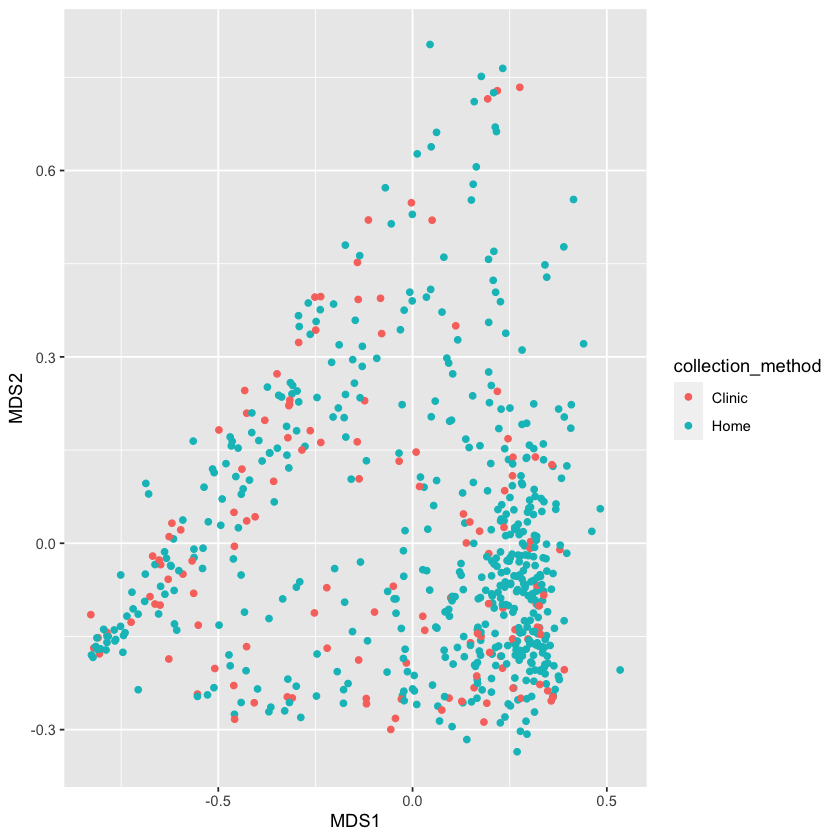

In [22]:
ggplot(baby_samples_only, aes(x=MDS1, y=MDS2, color=collection_method)) + geom_point()


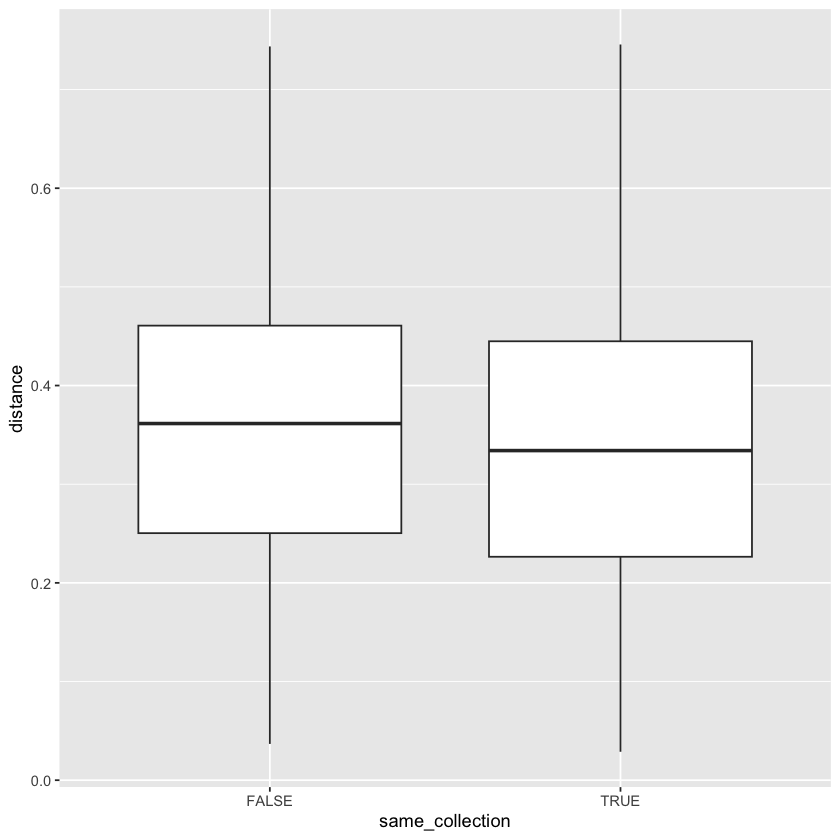

In [23]:
baby_bray_dists %>% ggplot(aes(same_collection, distance)) + geom_boxplot()


Maybe a bit of a collection method effect but this could be a result of confounding with age.

## Add in antibiotics

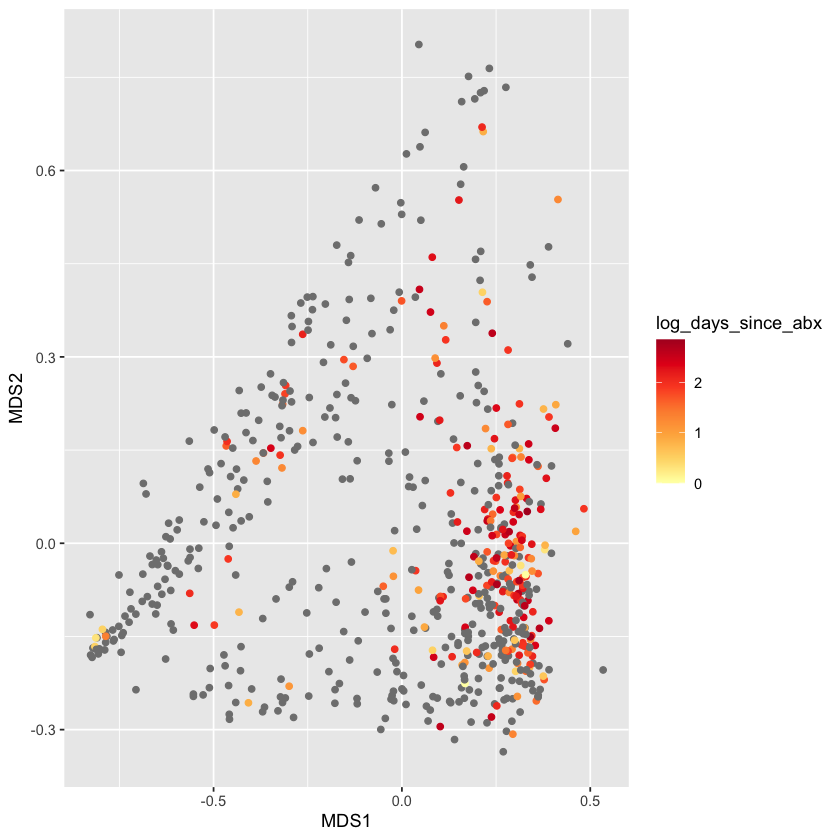

In [24]:
baby_samples_only %>% mutate(log_days_since_abx = log10(days_since_abx_end)) %>% ggplot(aes(x=MDS1, y=MDS2, color=log_days_since_abx)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)

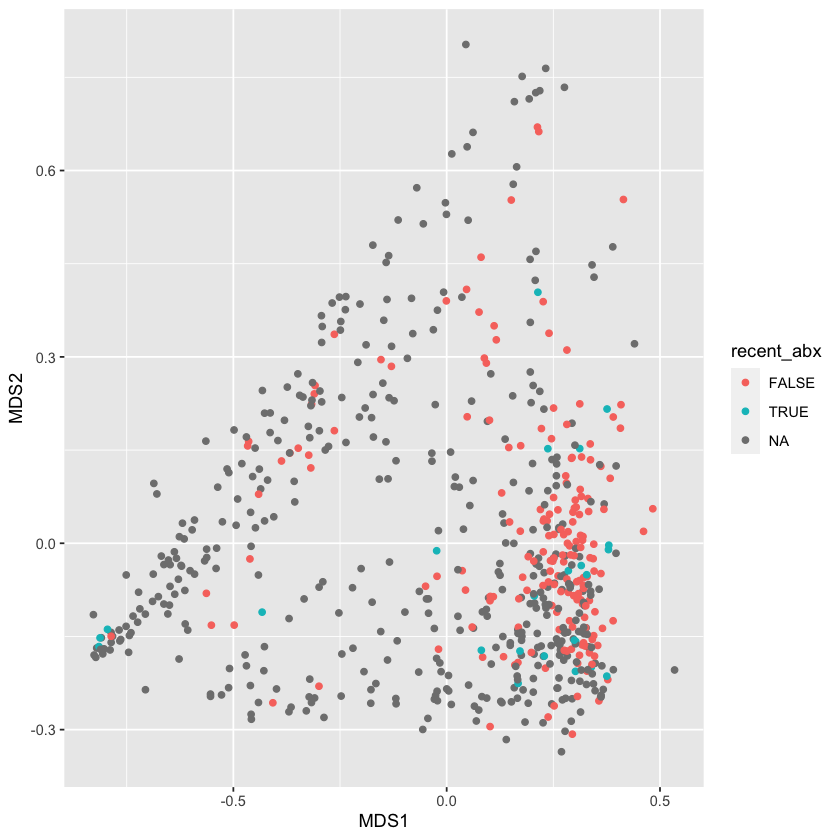

In [25]:
baby_samples_only %>% mutate(recent_abx = days_since_abx_end < 7) %>% ggplot(aes(x=MDS1, y=MDS2, color=recent_abx)) + geom_point()

No obvious antibiotics effect.

## Add in responder status

### Binary vaccine response

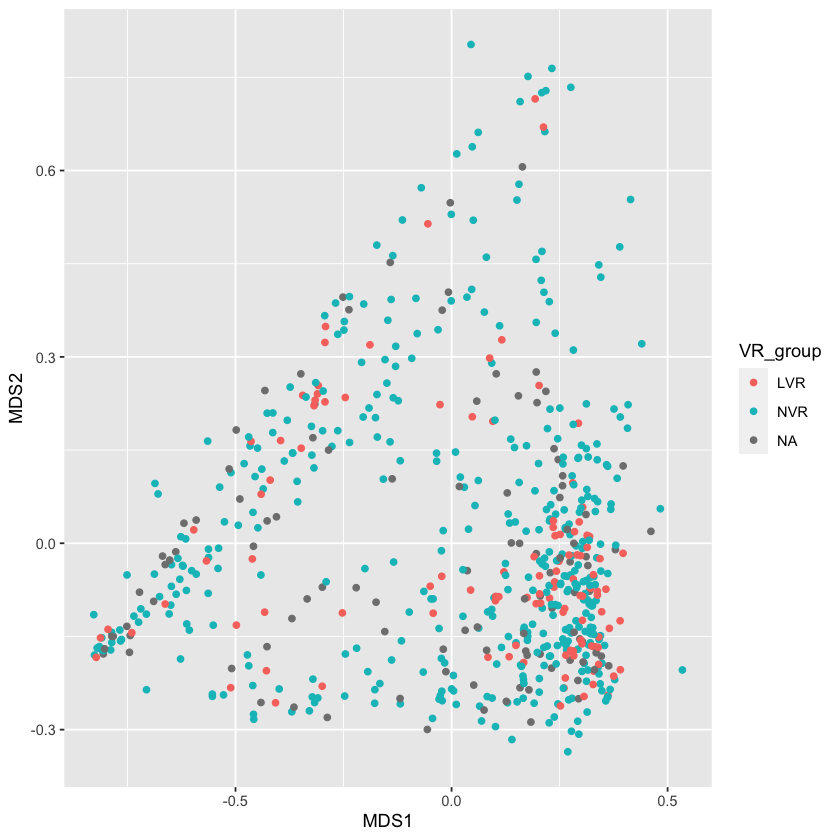

In [26]:
baby_samples_only %>% ggplot(aes(x=MDS1, y=MDS2, color=VR_group)) + geom_point()

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Using alpha for a discrete variable is not advised.”


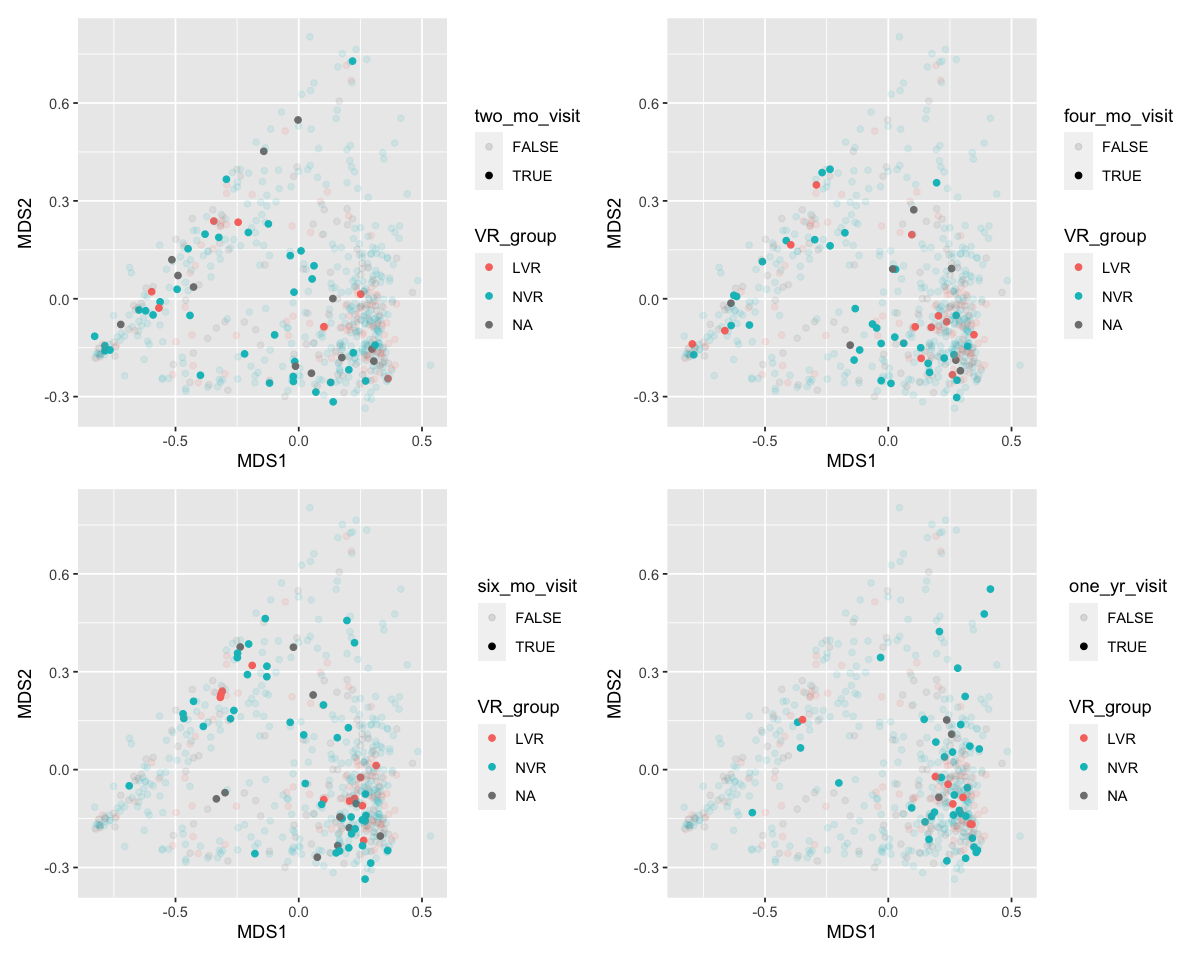

In [27]:
vr_two_month_plot = baby_samples_only %>% mutate('two_mo_visit' = VisitCode == 'V5') %>% ggplot(aes(x=MDS1, y=MDS2, color=VR_group, alpha=two_mo_visit)) + geom_point()
vr_four_month_plot = baby_samples_only %>% mutate('four_mo_visit' = VisitCode == 'V6') %>% ggplot(aes(x=MDS1, y=MDS2, color=VR_group, alpha=four_mo_visit)) + geom_point()
vr_six_month_plot = baby_samples_only %>% mutate('six_mo_visit' = VisitCode == 'V7') %>% ggplot(aes(x=MDS1, y=MDS2, color=VR_group, alpha=six_mo_visit)) + geom_point()
vr_one_year_plot = baby_samples_only %>% mutate('one_yr_visit' = VisitCode == 'V9') %>% ggplot(aes(x=MDS1, y=MDS2, color=VR_group, alpha=one_yr_visit)) + geom_point()

options(repr.plot.width = 10, repr.plot.height = 8)
vr_two_month_plot + vr_four_month_plot + vr_six_month_plot + vr_one_year_plot

No clear clustering by vaccine status, even within single time points.

### Continuous vaccine response

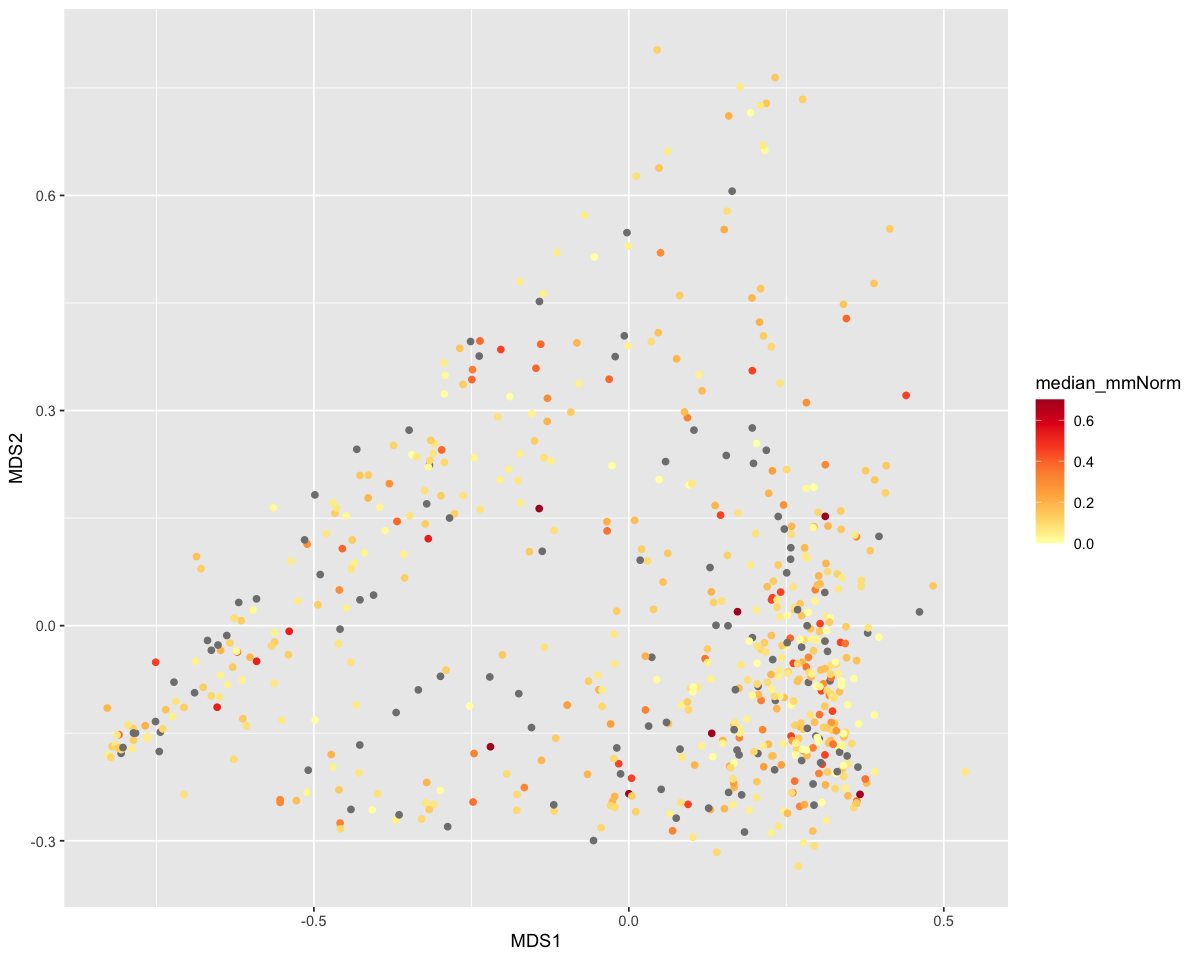

In [28]:
baby_samples_only %>% ggplot(aes(x=MDS1, y=MDS2, color=median_mmNorm)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Using alpha for a discrete variable is not advised.”


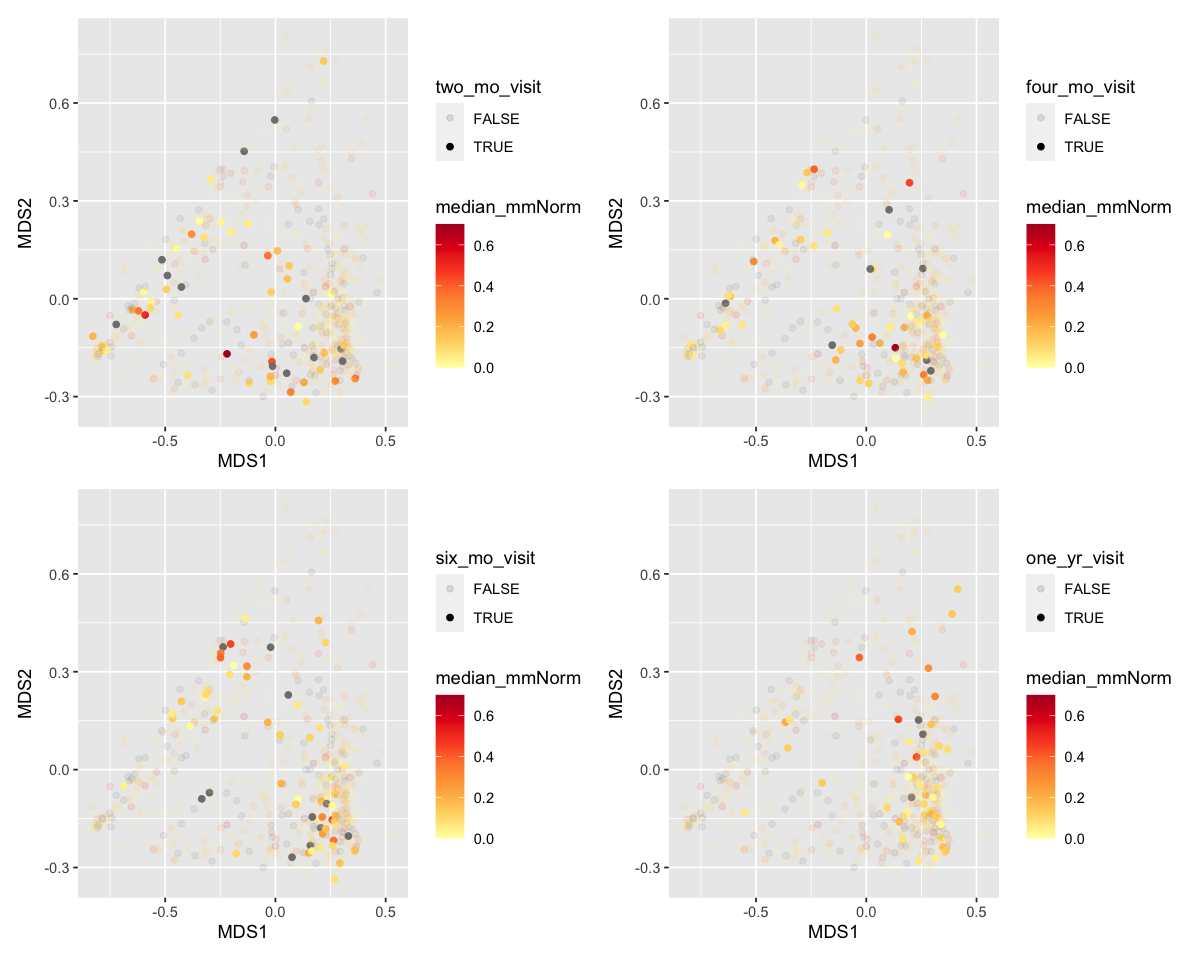

In [29]:
titer_two_month_plot = baby_samples_only %>% mutate('two_mo_visit' = VisitCode == 'V5') %>% ggplot(aes(x=MDS1, y=MDS2, color=median_mmNorm, alpha=two_mo_visit)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)
titer_four_month_plot = baby_samples_only %>% mutate('four_mo_visit' = VisitCode == 'V6') %>% ggplot(aes(x=MDS1, y=MDS2, color=median_mmNorm, alpha=four_mo_visit)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)
titer_six_month_plot = baby_samples_only %>% mutate('six_mo_visit' = VisitCode == 'V7') %>% ggplot(aes(x=MDS1, y=MDS2, color=median_mmNorm, alpha=six_mo_visit)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)
titer_one_year_plot = baby_samples_only %>% mutate('one_yr_visit' = VisitCode == 'V9') %>% ggplot(aes(x=MDS1, y=MDS2, color=median_mmNorm, alpha=one_yr_visit)) + geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)

options(repr.plot.width = 10, repr.plot.height = 8)
titer_two_month_plot + titer_four_month_plot + titer_six_month_plot + titer_one_year_plot

No clear clustering by vaccine status, even within single time points.